In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
import cv2
import imageio
import sklearn

from sklearn.model_selection import train_test_split
from PIL import Image
from os import listdir
from tqdm import tqdm_notebook
from skimage.color import rgb2gray
from collections import Counter
from sklearn.metrics import roc_auc_score,accuracy_score
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator


random_seed = 33


# <b> Load Images and Resize them</b>

In [2]:
# cell labels are 1 if infected, 0 if uninfected.
cell_labels = []

# cells image
cell_images = []

def read_images(file_path, label):
    images_addresses=os.listdir(file_path)
    images_addresses.remove('Thumbs.db')
    cells_image_array = np.zeros((len(images_addresses),125,125,3),dtype=np.int16)
    
    for ind,img_address in tqdm_notebook(enumerate(images_addresses),total=len(images_addresses)):
        path = file_path +'/'+ img_address
        image = Image.open(path)
        image = image.resize((125,125))
        image_array = np.asarray(image)
        image_array = image_array.astype(np.int32)
        cells_image_array[ind]=image_array         
        cell_images.append(image_array)
        cell_labels.append(label)
    return cells_image_array
    

In [3]:
infected_cells = read_images("D:/Neural/Project/cell_images/cell_images/Parasitized", 1)
uninfected_cells = read_images("D:/Neural/Project/cell_images/cell_images/Uninfected",0)

D:\Anaconda\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


# <b> Sample Images of Infected and Uninfected Cells </b>

In [4]:
def SampleCells(images_arr,title):

    fig, axes = plt.subplots(1, 10, figsize=(20,20))

    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.set_title(title,fontsize=20)
    plt.tight_layout()
    plt.show()

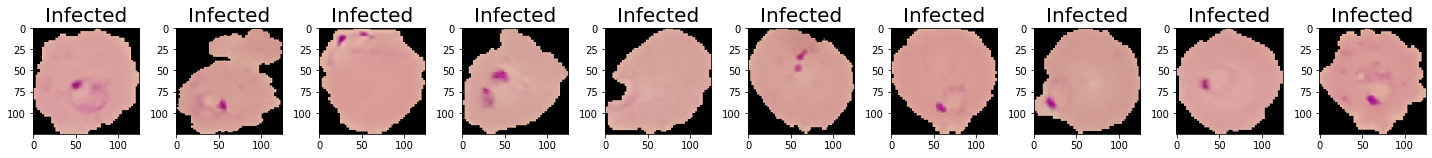

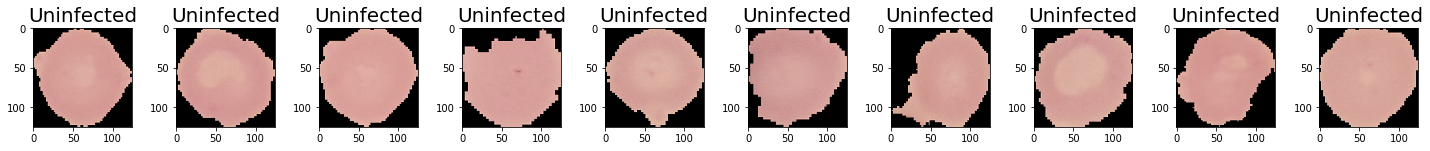

In [5]:
SampleCells(infected_cells,'Infected')
SampleCells(uninfected_cells,'Uninfected')

# <b> Data Exploration </b>
### select one sample from each category - Infected and Uninfected Cells

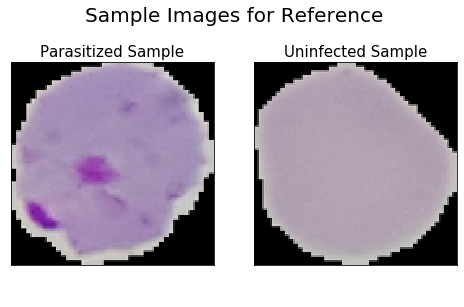

In [6]:
np.random.seed(random_seed)
rand=np.random.randint(infected_cells.shape[0])
parasitized_sample=infected_cells[rand]
np.random.seed(random_seed)
rand=np.random.randint(uninfected_cells.shape[0])
uninfected_sample=uninfected_cells[rand]

fig=plt.figure(figsize=(8,5))
plt.title("Sample Images for Reference",fontsize=20)
plt.axis('off')
ax1=fig.add_subplot(121)
ax1.imshow(parasitized_sample)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_title("Parasitized Sample",fontsize=15)
ax2=fig.add_subplot(122)
ax2.imshow(uninfected_sample)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_title("Uninfected Sample",fontsize=15)
plt.show()

### Analyse Blood Cell Color
#### To do so we plot the image histogram which shows Red-Green-Blue (RGB) color distribution for an image

In [7]:
def get_RGB_hist(sample_data,title,to_return=False):
    sample=Image.fromarray(sample_data.astype(np.uint8),'RGB')
    hist=sample.histogram()
    hist_r=hist[:256]
    hist_g=hist[256:512]
    hist_b=hist[512:]
    if(to_return==True):
        return hist_r,hist_g,hist_b
    x=np.arange(256)
    
    fig=plt.figure(figsize=(12,5))
    plt.title(title+'\n',fontsize=20)
    plt.axis('off')
    ax1=fig.add_subplot(121)
    ax1.imshow(sample)
    ax1.set_title("Image",fontsize=15)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax2=fig.add_subplot(122)
    ax2.plot(hist_r,color='red')
    ax2.fill_between(x,hist_r,color='red')
    ax2.plot(hist_g,color='green')
    ax2.fill_between(x,hist_g,color='green')
    ax2.plot(hist_b,color='blue')
    ax2.fill_between(x,hist_b,color='blue')
    ax2.set_ylim(0,3000)
    ax2.set_title("Image Histogram",fontsize=15)
    ax2.set_ylabel("Frequency")
    ax2.set_xlabel("Colour Intensity")
    plt.show()

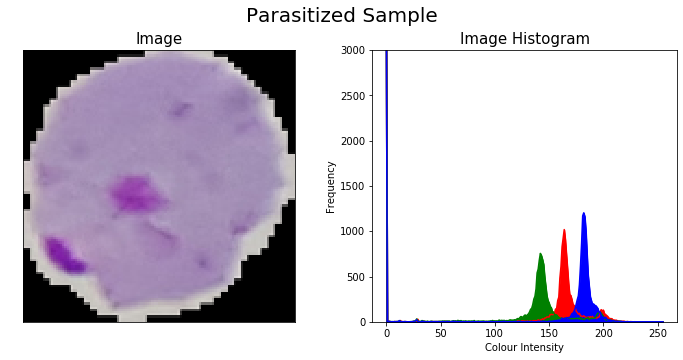

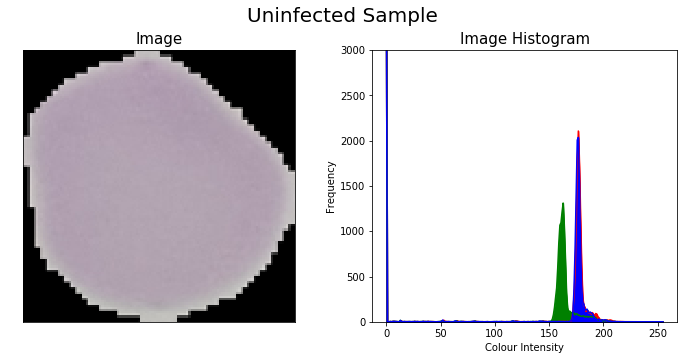

In [8]:
get_RGB_hist(parasitized_sample,"Parasitized Sample")
get_RGB_hist(uninfected_sample,"Uninfected Sample")

# <b> Training, Testing and Validation Data Preparation </b>

In [9]:
def reordering_list(old_list,order):
    new_list = []
    for i in order:
        new_list.append(old_list[i])
    return new_list

In [10]:
np.random.seed(seed=42)
indices = np.arange(len(cell_labels))
np.random.shuffle(indices)
indices = indices.tolist()
cell_labels = reordering_list(cell_labels,indices)
cell_images = reordering_list(cell_images,indices)

#change to arrays
image_array = np.array(cell_images)
label_array = np.array(cell_labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(image_array, label_array, test_size=0.3, random_state=100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=100)

In [12]:
print(X_train.shape, X_val.shape, X_test.shape)
print('Train:', Counter(y_train), '\nVal:', Counter(y_val), '\nTest:', Counter(y_test))

(17361, 125, 125, 3) (1929, 125, 125, 3) (8268, 125, 125, 3)
Train: Counter({1: 8703, 0: 8658}) 
Val: Counter({1: 978, 0: 951}) 
Test: Counter({0: 4170, 1: 4098})


# <b> CNN Basic Model </b>

### Label Encoding (One Hot Encoding)

In [13]:
y_train=tf.keras.utils.to_categorical(y_train,2)
y_test=tf.keras.utils.to_categorical(y_test,2)
y_val=tf.keras.utils.to_categorical(y_val,2)

### Model Hyperparameter Values

In [14]:
EPOCHS = 20
BATCH_SIZE = 64

### CNN Basic Model Architecture

In [15]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=16,kernel_size=2,padding="same",activation="relu",input_shape=(125,125,3)))
model_cnn.add(MaxPooling2D(pool_size=2))
model_cnn.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=2))
model_cnn.add(Conv2D(filters=64,kernel_size=2,padding="same",activation="relu"))
model_cnn.add(MaxPooling2D(pool_size=2))
model_cnn.add(Dropout(0.2))
model_cnn.add(Flatten())
model_cnn.add(Dense(500,activation="relu"))
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(2,activation="softmax"))#2 represent output layer neurons 


In [16]:
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 125, 125, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 64)        0

### Train the Model

In [17]:
history_bsic_cnn = model_cnn.fit(X_train,y_train, batch_size=256,
                              epochs = 20, validation_data = (X_val,y_val))

Train on 17361 samples, validate on 1929 samples
Epoch 1/20
17361/17361 [==============================] - 15s 880us/sample - loss: 29.7327 - accuracy: 0.5608 - val_loss: 0.6507 - val_accuracy: 0.6195
Epoch 2/20
17361/17361 [==============================] - 8s 462us/sample - loss: 0.6248 - accuracy: 0.6527 - val_loss: 0.6003 - val_accuracy: 0.6739
Epoch 3/20
17361/17361 [==============================] - 8s 459us/sample - loss: 0.5855 - accuracy: 0.6920 - val_loss: 0.5764 - val_accuracy: 0.7045
Epoch 4/20
17361/17361 [==============================] - 8s 474us/sample - loss: 0.5405 - accuracy: 0.7278 - val_loss: 0.5322 - val_accuracy: 0.7429
Epoch 5/20
17361/17361 [==============================] - 8s 463us/sample - loss: 0.4464 - accuracy: 0.7932 - val_loss: 0.4322 - val_accuracy: 0.7880
Epoch 6/20
17361/17361 [==============================] - 8s 465us/sample - loss: 0.3334 - accuracy: 0.8642 - val_loss: 0.3577 - val_accuracy: 0.8455
Epoch 7/20
17361/17361 [=========================

# Transfer Learning using VGG-19 convolutional neural network

## Image Augmentation 

In [18]:
train_image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')
val_data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)


train_generator = train_image_data_generator.flow(X_train, y_train, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_data_gen.flow(X_val, y_val, batch_size=BATCH_SIZE, shuffle=False)

## Fine-tuned Pre-trained VGG-19 CNN Model

### Build Model Architecture

In [19]:
vgg_cnn = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=(125,125,3))
# Freeze the layers
vgg_cnn.trainable = True

set_trainable = False
for layer in vgg_cnn.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [20]:
base_vgg_cnn = vgg_cnn
base_vgg_out = base_vgg_cnn.output
vgg_pool_out = tf.keras.layers.Flatten()(base_vgg_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(vgg_pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)

out = tf.keras.layers.Dense(2, activation='softmax')(drop1)

model_vgg_cnn = tf.keras.Model(inputs=base_vgg_cnn.input, outputs=out)

In [21]:
model_vgg_cnn.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=1e-5), metrics=['accuracy'])
model_vgg_cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0     

### Train the Model

In [22]:
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size

history_vgg_cnn = model_vgg_cnn.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=20,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch,
                              verbose=1)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 271 steps, validate for 30 steps
Epoch 1/20
271/271 [==============================] - 110s 406ms/step - loss: 0.2084 - accuracy: 0.9205 - val_loss: 0.1241 - val_accuracy: 0.9573
Epoch 2/20
271/271 [==============================] - 150s 555ms/step - loss: 0.1375 - accuracy: 0.9535 - val_loss: 0.1139 - val_accuracy: 0.9589
Epoch 3/20
271/271 [==============================] - 188s 695ms/step - loss: 0.1234 - accuracy: 0.9580 - val_loss: 0.1059 - val_accuracy: 0.9620
Epoch 4/20
271/271 [==============================] - 213s 785ms/step - loss: 0.1173 - accuracy: 0.9605 - val_loss: 0.0999 - val_accuracy: 0.9630
Epoch 5/20
271/271 [==============================] - 212s 783ms/step - loss: 0.1116 - accuracy: 0.9617 - val_loss: 0.1068 - val_accuracy: 0.9609
Epoch 6/20
271/271 [==============================] - 216s 796ms/step - loss: 0.1082 - accuracy: 0.9638 - val_loss: 0.0939 - val_accuracy: 0.9651
Epoch 7/20
271/271 [===========

# Model Evaluation for Basic CNN and VGG-19 CNN

### Retrieve Training and Validation Dataset Accuracy and Loss

In [23]:
#accuracy 
#for Basic CNN
train_accuracy_cnn = history_bsic_cnn.history['accuracy']
validation_accuracy_cnn = history_bsic_cnn.history['val_accuracy']

#for VGG-19 cnn
train_accuracy_vgg = history_vgg_cnn.history['accuracy']
validation_accuracy_vgg = history_vgg_cnn.history['val_accuracy']

#loss 
#for Basic CNN
train_loss_cnn = history_bsic_cnn.history['loss']
validation_loss_cnn = history_bsic_cnn.history['val_loss']

#for VGG-19 CNN
train_loss_vgg = history_vgg_cnn.history['loss']
validation_loss_vgg = history_vgg_cnn.history['val_loss']


## Plot Accuracy and Loss Graph for Basic CNN and VGG-19 CNN Models

In [24]:
def plot_accuracy_loss_graph(train_accuracy, validation_accuracy, train_loss, validation_loss, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    t = f.suptitle(title, fontsize=18)
    f.subplots_adjust(top=0.85, wspace=0.3)

    epoch_range = len(train_accuracy)+1
    epoch_list = list(range(1,epoch_range))

    ax1.plot(epoch_list, train_accuracy, label='Train Accuracy')
    ax1.plot(epoch_list, validation_accuracy, label='Validation Accuracy')
    ax1.set_xticks(np.arange(1, epoch_range, 5))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")

    ax2.plot(epoch_list, train_loss, label='Train Loss')
    ax2.plot(epoch_list, validation_loss, label='Validation Loss')
    ax2.set_xticks(np.arange(1, epoch_range, 5))
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")

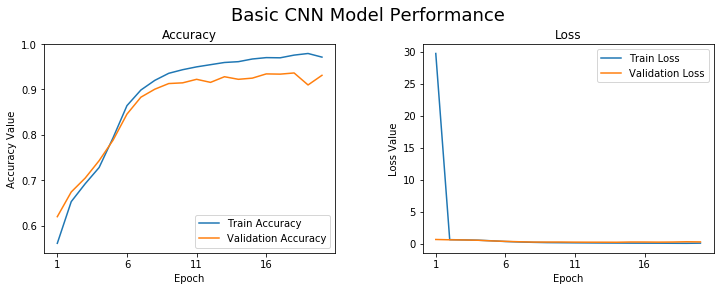

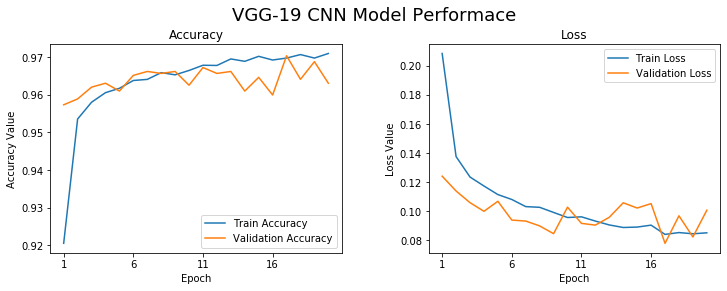

In [25]:
plot_accuracy_loss_graph(train_accuracy_cnn, validation_accuracy_cnn, train_loss_cnn, validation_loss_cnn, "Basic CNN Model Performance")
plot_accuracy_loss_graph(train_accuracy_vgg, validation_accuracy_vgg, train_loss_vgg, validation_loss_vgg, "VGG-19 CNN Model Performace")

## Test Data Accuracy for Basic CNN and VGG-19 CNN Model

In [26]:
accuracy_cnn = model_cnn.evaluate(X_test, y_test, verbose=1)
print('\n', 'Basic CNN Model Test_Accuracy:-', accuracy_cnn[1])

test_scaled = X_test / 255.
accuracy_vgg = model_vgg_cnn.evaluate(test_scaled, y_test, verbose=1)
print('\n\n\n', 'VGG19 CNN Model Test_Accuracy:-', accuracy_vgg[1])

8268/8268 [==============================] - 8s 1ms/sample - loss: 0.2646 - accuracy: 0.9305

 Basic CNN Model Test_Accuracy:- 0.9304548
8268/8268 [==============================] - 31s 4ms/sample - loss: 0.1482 - accuracy: 0.9624



 VGG19 CNN Model Test_Accuracy:- 0.9623851


##  Confusion Matrix for Basic CNN and VGG-19 CNN Model

In [31]:
from sklearn.metrics import confusion_matrix, classification_report , accuracy_score
import seaborn as sns
def evaluation_matrix(X_test, y_test,model,title):
    pred = model.predict(X_test)
    pred = np.argmax(pred,axis = 1) 
    y_true = np.argmax(y_test,axis = 1)
    
    fig = plt.figure(figsize=(5,5))
    ax =  fig.gca()
    sns.heatmap(confusion_matrix(y_true , pred),ax=ax,cmap='Blues',annot=True,fmt='g',
               xticklabels = ['Infected','Uninfected'],
               yticklabels=['Infected','Uninfected'])
    ax.set_ylabel('Actual',fontsize=20)
    ax.set_xlabel('Predicted',fontsize=20)
    plt.title(title,fontsize=24)
    plt.show()
    
    print('\n\n\n{} \n{}'.format(classification_report(y_true , pred) , 
                           accuracy_score(y_true , pred)))
    
    plt.figure(1 , figsize = (15 , 9))
    n = 0 
    for i in range(25):
        n += 1 
        r = np.random.randint( 0  , X_test.shape[0] , 1)
        plt.subplot(5 , 5 , n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(X_test[r[0]])
        plt.title('true {} : pred {}'.format(y_true[r[0]] , pred[r[0]]) )
        plt.xticks([]) , plt.yticks([])

    plt.show()

### Basic CNN Model

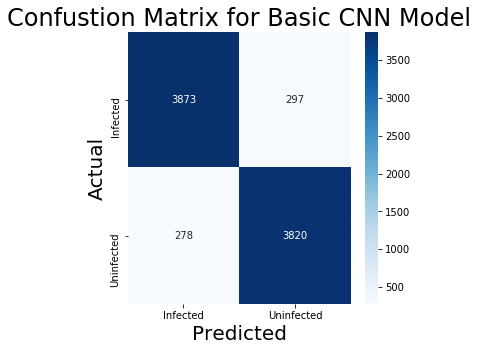




              precision    recall  f1-score   support

           0       0.93      0.93      0.93      4170
           1       0.93      0.93      0.93      4098

    accuracy                           0.93      8268
   macro avg       0.93      0.93      0.93      8268
weighted avg       0.93      0.93      0.93      8268
 
0.9304547653604257


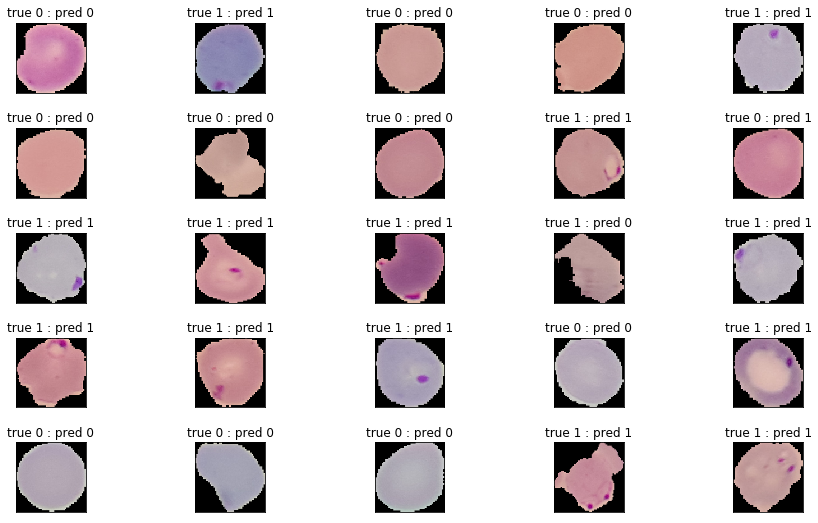

In [32]:
evaluation_matrix(X_test, y_test, model_cnn, 'Confustion Matrix for Basic CNN Model')

### VGG-19 CNN Model

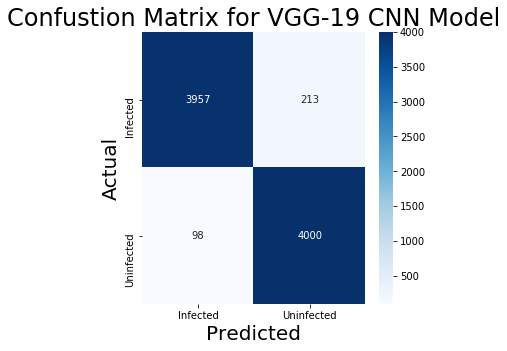




              precision    recall  f1-score   support

           0       0.98      0.95      0.96      4170
           1       0.95      0.98      0.96      4098

    accuracy                           0.96      8268
   macro avg       0.96      0.96      0.96      8268
weighted avg       0.96      0.96      0.96      8268
 
0.962385099177552


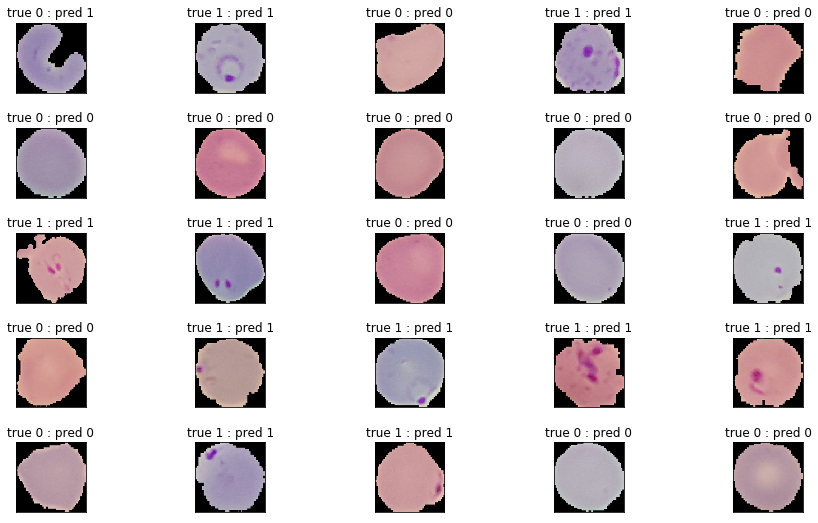

In [33]:
evaluation_matrix(test_scaled, y_test, model_vgg_cnn, 'Confustion Matrix for VGG-19 CNN Model')